# **Fitting a nonlinear surface to a pointcloud**

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## **Data generation**

![BMI](bmi.jpg)

Generate a surface with NxN points replicating the BMI table above. Height (H) varies from 1.4 to 2.1 meters and weight (W) varies from 40 to 130 kilograms. BMI values are computes as W/H^2. H, W and BMI are respectively mapped to x, y and z axes.

In [2]:
N = 20
min_height, max_height, min_weight, max_weight = 1.4, 2.1, 40, 130
min_bmi = int(min_weight/(max_height**2)+0.5)
max_bmi = int(max_weight/(min_height**2)+0.5)

# x and y coordinates
xtics = np.linspace(min_height, max_height, N)
ytics = np.linspace(min_weight, max_weight, N)

# 2D grid on x and y axes
x, y = np.meshgrid(xtics, ytics)

# use BMI as z coordinates
z = np.divide(y, np.square(x))

# input
X = np.concatenate((x.reshape((-1,1)), y.reshape((-1,1))), axis=1)
print(X.shape)

# output
Y = z.reshape((-1,1))
print(Y.shape)

(400, 2)
(400, 1)


## **Visualize surface**

Plot the surface created in the previous step. The colors of the plot follow the pattern of the BMI table.

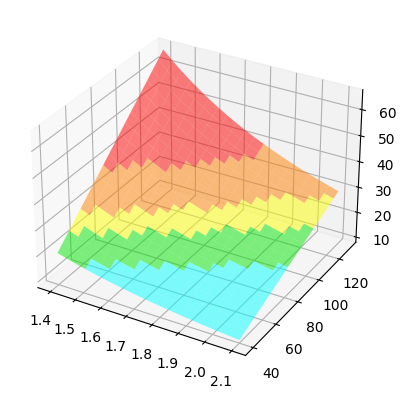

In [3]:
def show_surface(x, y, z, W0=None, b0=None, W1=None, b1=None):
  # 0-18: cyan / 19-24: green / 25-29: yellow / 30-39: orange / 40-*: red
  colors = [(0.0,1.0,1.0,0.5)]*(19-min_bmi) + [(0.0,0.9,0.0,0.5)]*6 + [(1.0,1.0,0.0,0.5)]*5 + [(1.0,0.5,0.0,0.5)]*10 + [(1.0,0.0,0.0,0.5)]*(max_bmi-39)
  cmap = matplotlib.colors.LinearSegmentedColormap.from_list('BMI', colors, N=len(colors))

  # plot surface
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.plot_surface(x, y, z, cmap=cmap)

  # plot line
  if W0 is not None and b0 is not None and W1 is not None and b1 is not None:
    X_ = np.concatenate((x.reshape((-1,1)), y.reshape((-1,1))), axis=1)
    H = np.maximum(np.matmul(X_, np.transpose(W0)) + b0, 0)
    z_ = (np.matmul(H, np.transpose(W1)) + b1).reshape(z.shape)
    ax.plot_wireframe(x, y, z_, color='black', lw=1)

  plt.show()

show_surface(x, y, z)

## **Initialize parameters**

Create a vector of weights (one weight per input dimension in each vector) and one bias for each output dimension.

Mean Squared Error: 987.6626799740377


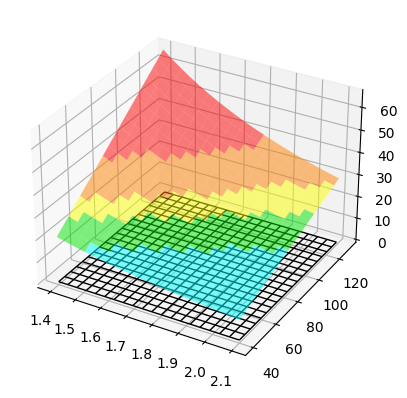

In [4]:
def loss(X, Y, W0, b0, W1, b1):
  H = np.maximum(np.matmul(X, np.transpose(W0)) + b0, 0)
  Y_ = np.matmul(H, np.transpose(W1)) + b1
  return np.mean(np.square(Y_ - Y))

# weight initialization
hidden_size = 8
W0 = np.zeros((hidden_size,2), dtype=np.float32)
b0 = np.zeros((hidden_size,), dtype=np.float32)
W1 = np.zeros((1,hidden_size), dtype=np.float32)
b1 = np.zeros((1,), dtype=np.float32)

print('Mean Squared Error:', loss(X, Y, W0, b0, W1, b1))
show_surface(x, y, z, W0, b0, W1, b1)

## **Gradient descent**

Train a nonlinear function that maps xy-coordinates into z-coordinates using multiple gradient descent updates..

Mean Squared Error before training: 0.16804115268880682


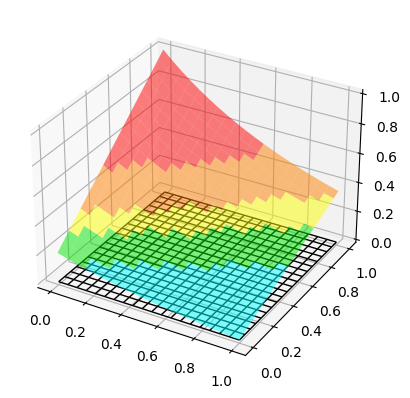


Mean Squared Error after 1 training iteration(s): 0.04444917596146645


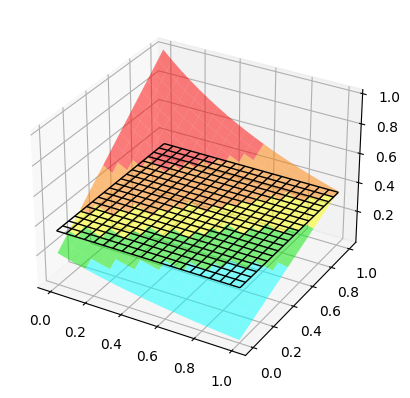


Mean Squared Error after 2 training iteration(s): 0.04444917596146645


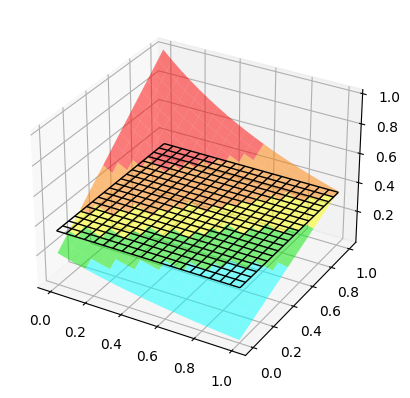


Mean Squared Error after 4 training iteration(s): 0.04444917596146645


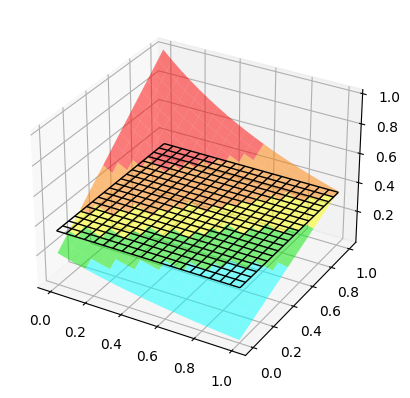


Mean Squared Error after 8 training iteration(s): 0.04444917596146645


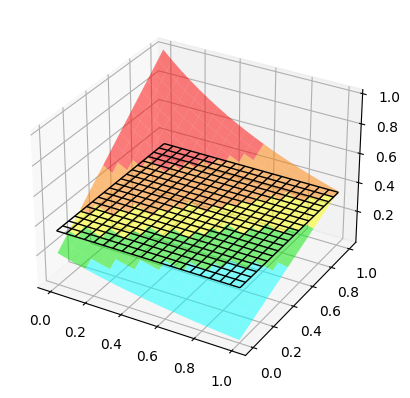


Mean Squared Error after 16 training iteration(s): 0.04444917596146645


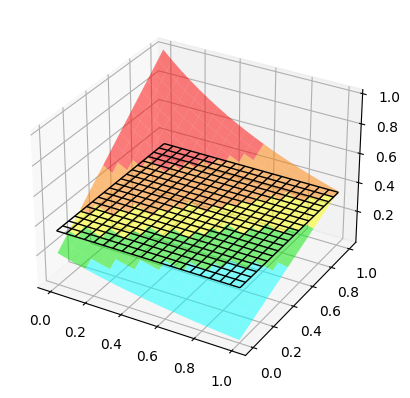


Mean Squared Error after 32 training iteration(s): 0.04444917596146645


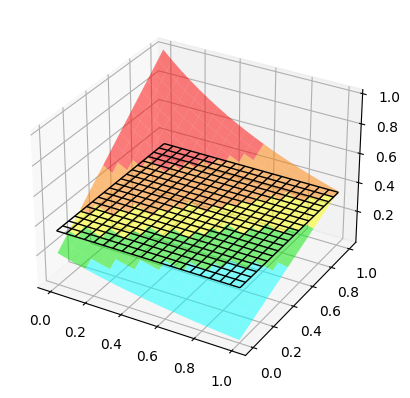


Mean Squared Error after 64 training iteration(s): 0.04444917596146645


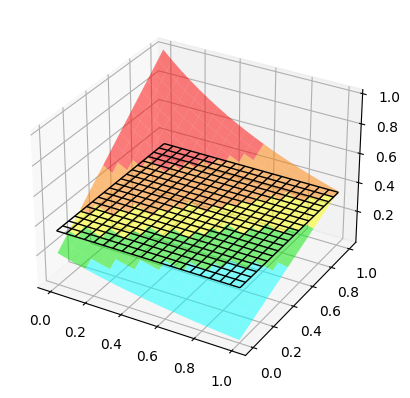


Mean Squared Error after 128 training iteration(s): 0.04444917596146645


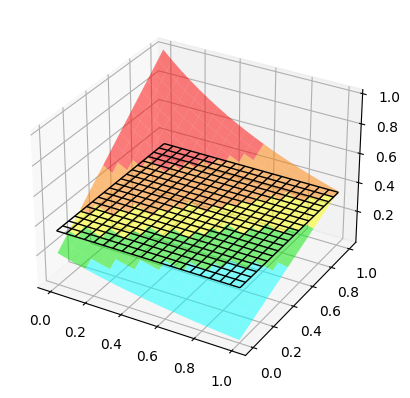


Mean Squared Error after 256 training iteration(s): 0.04444917596146645


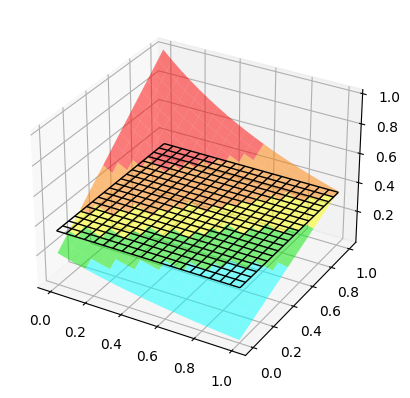

In [5]:
def gradient_descent_step(X, Y, W0, b0, W1, b1, learning_rate):
  H_ = np.matmul(X, np.transpose(W0)) + b0
  H = np.maximum(H_, 0) # ReLU
  Y_ = np.matmul(H, np.transpose(W1)) + b1

  delta_Y = Y_ - Y
  W1_grad = np.matmul(np.transpose(delta_Y), H) / H.shape[0]
  b1_grad = np.mean(delta_Y, axis=0)

  delta_H = np.multiply(np.matmul(delta_Y, W1), np.where(H_>=0.0, 1.0, 0.0))
  W0_grad = np.matmul(np.transpose(delta_H), X) / X.shape[0]
  b0_grad = np.mean(delta_H, axis=0)

  W0_ = W0 - learning_rate * W0_grad
  b0_ = b0 - learning_rate * b0_grad
  W1_ = W1 - learning_rate * W1_grad
  b1_ = b1 - learning_rate * b1_grad

  return W0_, b0_, W1_, b1_

# data normalization
x_ = (x-min_height)/(max_height-min_height)
y_ = (y-min_weight)/(max_weight-min_weight)
z_ = (z-min_bmi)/(max_bmi-min_bmi)

X_ = np.concatenate((x_.reshape((-1,1)), y_.reshape((-1,1))), axis=1)
Y_ = z_.reshape((-1,1))

# weight initialization
hidden_size = 8
W0 = np.zeros((hidden_size,2), dtype=np.float32)
b0 = np.zeros((hidden_size,), dtype=np.float32)
W1 = np.zeros((1,hidden_size), dtype=np.float32)
b1 = np.zeros((1,), dtype=np.float32)

# gradient descent optimization
print('Mean Squared Error before training:', loss(X_, Y_, W0, b0, W1, b1))
show_surface(x_, y_, z_, W0, b0, W1, b1)

log_count = 1
for i in range(256):
  W0, b0, W1, b1 = gradient_descent_step(X_, Y_, W0, b0, W1, b1, 1.0)
  if i == log_count-1:
    print('\nMean Squared Error after {} training iteration(s):'.format(log_count), loss(X_, Y_, W0, b0, W1, b1))
    show_surface(x_, y_, z_, W0, b0, W1, b1)
    log_count *= 2

## **Random weight initialization**

Normalize training data in a way that x, y, and z values are in the range from 0 to 1.

Mean Squared Error before training: 0.1611522333001773


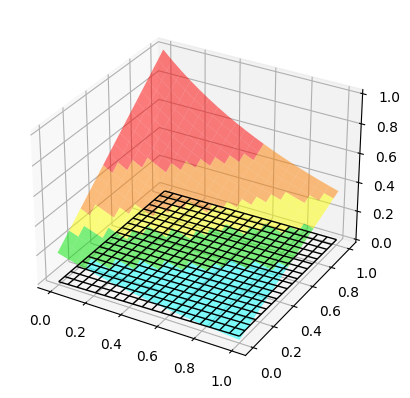


Mean Squared Error after 1 training iteration(s): 0.11805969237721073


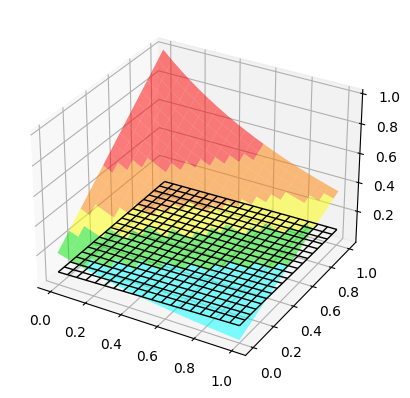


Mean Squared Error after 2 training iteration(s): 0.09105342359570705


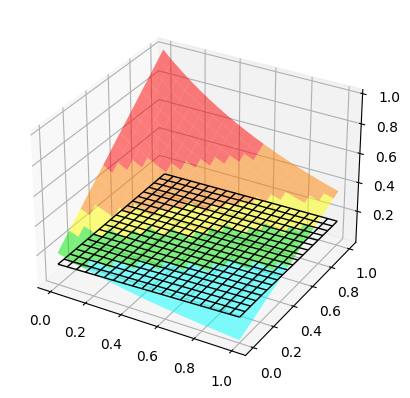


Mean Squared Error after 4 training iteration(s): 0.06355970435597834


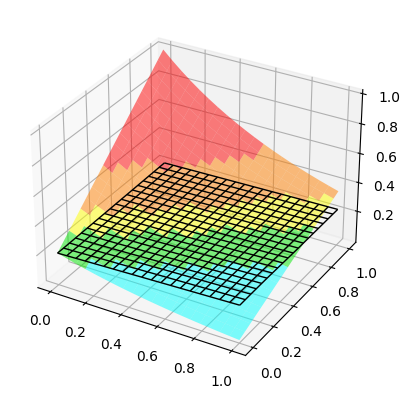


Mean Squared Error after 8 training iteration(s): 0.04829416318047395


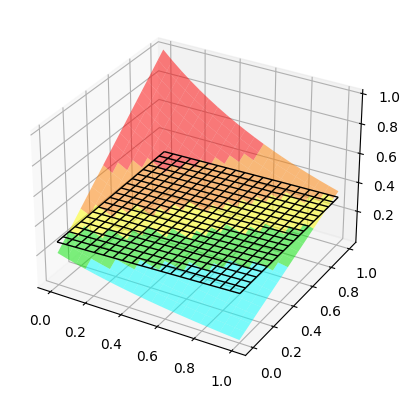


Mean Squared Error after 16 training iteration(s): 0.04386464685508225


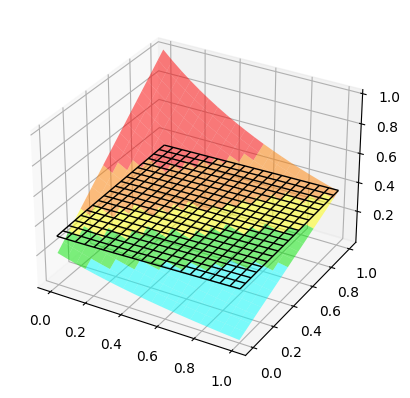


Mean Squared Error after 32 training iteration(s): 0.040234811518337736


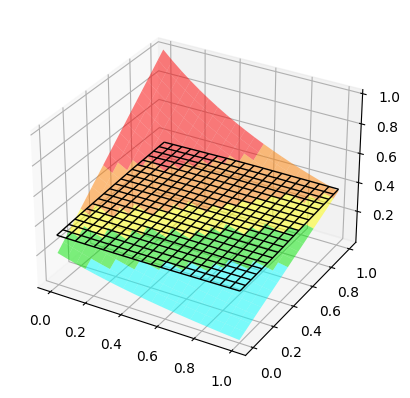


Mean Squared Error after 64 training iteration(s): 0.03412930798468908


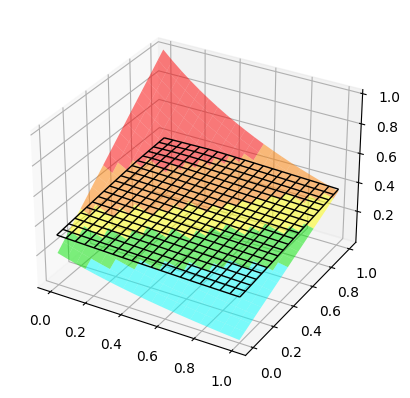


Mean Squared Error after 128 training iteration(s): 0.018336150588808033


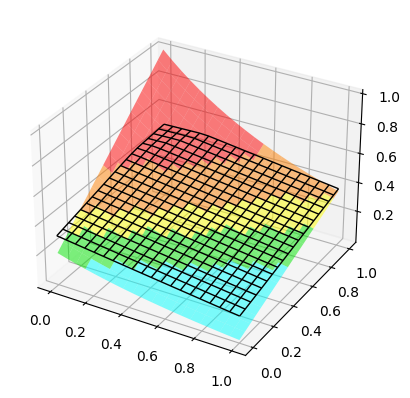


Mean Squared Error after 256 training iteration(s): 0.002906473088283047


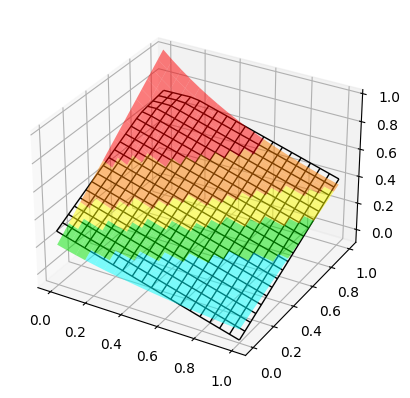


Mean Squared Error after 512 training iteration(s): 0.0020751781568047797


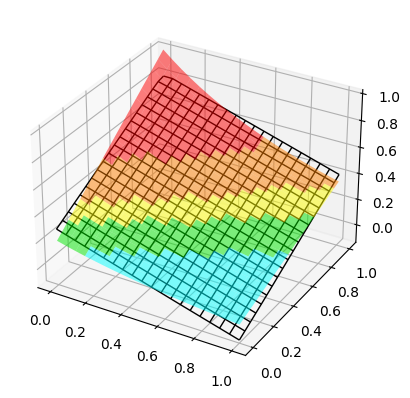


Mean Squared Error after 1024 training iteration(s): 0.0017517127220298143


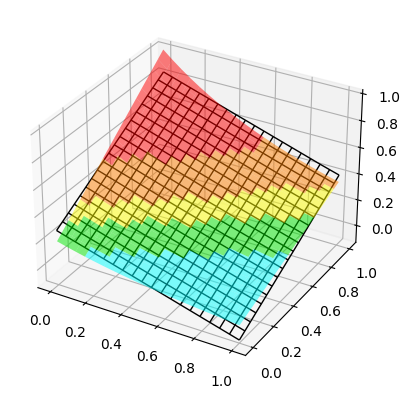


Mean Squared Error after 2048 training iteration(s): 0.0010478260038062747


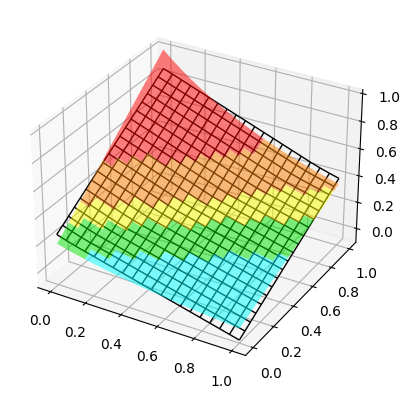


Mean Squared Error after 4096 training iteration(s): 0.00029695511972885243


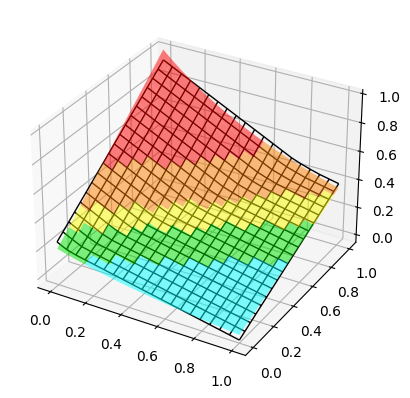

In [8]:
# weight initialization
hidden_size = 8
W0 = np.random.normal(0, 0.1, (hidden_size,2)).astype(np.float32)
b0 = np.zeros((hidden_size,), dtype=np.float32)
W1 = np.random.normal(0, 0.1, (1,hidden_size)).astype(np.float32)
b1 = np.zeros((1,), dtype=np.float32)

# gradient descent optimization
print('Mean Squared Error before training:', loss(X_, Y_, W0, b0, W1, b1))
show_surface(x_, y_, z_, W0, b0, W1, b1)

log_count = 1
for i in range(4096):
  W0, b0, W1, b1 = gradient_descent_step(X_, Y_, W0, b0, W1, b1, 0.2)
  if i == log_count-1:
    print('\nMean Squared Error after {} training iteration(s):'.format(log_count), loss(X_, Y_, W0, b0, W1, b1))
    show_surface(x_, y_, z_, W0, b0, W1, b1)
    log_count *= 2